## Homework 2 - Model Selection and Regularization
In this homework, we will explore the need for regularization and cross validation. Your goal is to determine
the *true* model that exists in this superfluous data set. 

Name: Yuan Zhang

UNI: yz3455

Just a quick reminder on how to submit homework solutions:
    
``` $ git add myhomeworksolutions.ipynb ```

``` $ git commit -m "added my homework 1 solutions" ```

``` $ git push origin master $ ```

Run the cell below to load the libraries

In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
from sklearn.neighbors import KNeighborsRegressor
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd

## Problem 1: Not So Nearest Neighbors

In this problem we look into the **curse of dimensionality**  (https://en.wikipedia.org/wiki/Curse_of_dimensionality).

Recall from lecture that when solving the ordinary least squares, the solution to 

$$\min_f \mathbb{E}_{y \lvert x} (y - f(x))^2,$$

is $$ f(x) = \mathbb{E}(y \lvert x).$$


As usual though, we only have access to the sampled data $(\mathbf{x}_i, y_i)$. Thus we seek to find (as seen in lecture)

$$ \hat f(x) :=  \hat{\mathbb{E}}(y \lvert x).$$

The simple approach which is the most natural way to estimate $f$ is to average $y_i$ over over observations $x_i$ such that $x_i=x$

$$ \hat{\mathbb{E}}(y \lvert x) = \frac{1}{N_{x_i=x}} \sum_{x_i, x_i=x} y_i,$$

where $N_{x_i=x}$ is the number of points such that $x_i=x$. **But we cannot do this since we only have access to the training data, not all $x$, and we generally have at most one instance of each $x_i$**. Thus we settle for

$$ \hat{\mathbb{E}}(y \lvert x) := \frac{1}{k} \sum_{x_i \in N_k(x)} y_i,$$

where $N_k(x)$ denotes the set of the $k$ closest points to $x$. 

### Goal of this problem:
To understand how the set $N_k(x)$ behaves as we increase the dimension. The intuition is that it's much harder to find points close to $x$ as we increase the *degrees of freedom* of our samples. We will see that this means we have to search larger distances to find these points, and these points may not reflect the value of $y_i$ well at all!

**[15 points]** a) Run the code below to create a sample from a $p$ dimensional uniform distribution, denoted $\mathcal{U}(-1,1)^p$.  



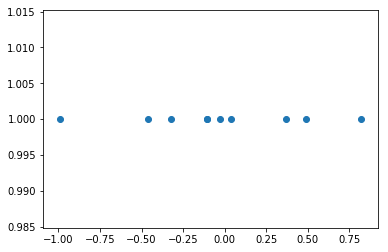

In [9]:
p=1
X=np.zeros(shape=(10,p))
for k in range(X.shape[1]):
    X[:,k] = np.random.uniform(-1,1,10)
plt.scatter(X[:,k] ,[1]*10)
plt.show()

What is the distance of $x=0$ to its nearest neighbor? You can use `np.min` and `np.abs` here. 

In [10]:
dist = np.min(np.abs(X))
print(dist)

0.02889827537672751


Repeat the above but now for $p=2$ and make a scatter plot on $[-1,1] \times [-1,1]$. Use `X=np.zeros(shape=(10,p))` to initialize the matrix, and make sure that each row is a point sampled from a 2d uniform distribution (you can do this by setting each column to be sampled from a 1d uniform distribution). 

Finally, repeat the problem for various values of $p$, ($p=10,20,100$, etc. ). What do you notice about the distances? Can you explain why this may be happening?


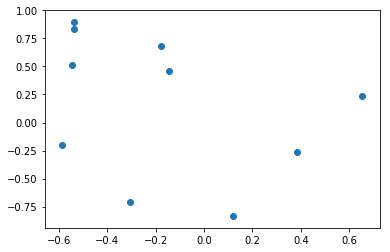

[ 1.34481979  2.00636316  3.50549542  5.23816535 12.52167551 17.87972401]


In [25]:
p=2
X=np.zeros(shape=(10,p))
for k in range(X.shape[1]):
    X[:,k] = np.random.uniform(-1,1,10)
plt.scatter(X[:,0],X[:,1])
plt.show()

p=(10,20,50,100,500,1000)
dist=np.zeros(len(p))
for i in range(len(p)):
    X=np.zeros(shape=(10,p[i]))
    Xsquare = np.zeros(shape=(10,p[i]))
    Xsum = np.zeros(10)
    for k in range(X.shape[1]):
        X[:,k] = np.random.uniform(-1,1,10)
        Xsquare[:,k] = X[:,k]**2
    Xsum = np.sum(Xsquare,axis=1)
    dist[i] = min(np.sqrt(Xsum))
print(dist)
        

According to the algorithm method, we can see as value $p$ increased, we are adding more non-negative numbers(calculated by squareroot of sum of non-negative numbers) to the distance. Theoretically, distance will increase as $p$ increased.

**[10 points]** b)  Let's do something more precise to find out what's happening. Assume that there are $N$ points which are uniformly distributed in a sphere in $\mathbb{R}^n$. Find the probabiltity that the nearest neighbor of the origin is at a distance larger than or equal to $r$ and show that it is

$$  P(y \geq R) = \left (1- r^p\right)^N.$$

You can assume the volume of the sphere in $\mathbb{R}^p$ is $C_pr^p$. 

**Hint:** First find the proability that given one point, that it is not within a ball of radius $r$ centered around the origin. Then use independence to find the case when there are $N$ points. 

**[5 points]** c) Given your solution to part a), what is the median of the above distribution? 

**[5 points]** d)  Make a plot of $(p, P(y \geq 1/2))$ for  $N=50$. What happens as $p \to +\infty$ for fixed $N$? (ie. the number of poitns is fixed, but the dimension tends to $+\infty$). What does this tell you? In other words, where are all of the points accumulating?

b)

The probability of $1$ point within the distance $r$ is $r^p$, so that the nearest neighbor of the origin is at a distance larger than or equal to $r$ is $(1-r^p)^N$

c)

We can calculate median by this:

In [39]:
p=1
X=np.zeros(shape=(10,p))
for k in range(X.shape[1]):
    X[:,k] = np.random.uniform(-1,1,10)
np.median(X)

-0.046600612915625006

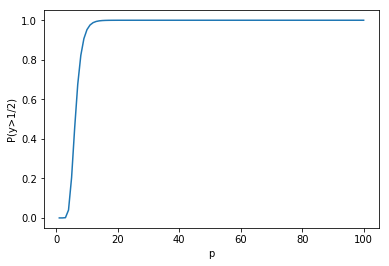

In [50]:
N=50
p = np.linspace(1,100,100)
r = 0.5
prob = (1-r**p)**N

plt.plot(p, prob)
plt.xlabel("p")
plt.ylabel("P(y>1/2)")
plt.show()

According to this, we can see as $p \to +\infty$ for fixed $N=50$, $P(y \geq 1/2)\to 1$

** [2 points] ** e) Run the code in the cell below. The second cell computes the nearest neighbors regressor for this data. 

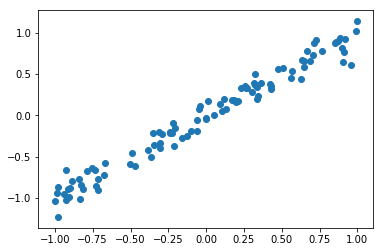

In [63]:

%matplotlib inline
X = np.random.uniform(-1,1,100)
epsilon = np.random.normal(0,0.1,100)
y = X + epsilon
plt.scatter(X,y)
plt.show()

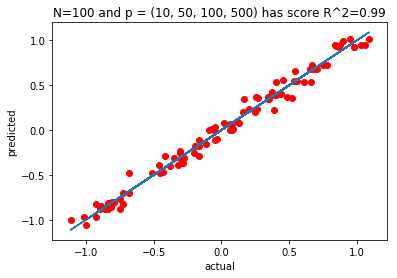

In [66]:
T = np.linspace(-1,1,1000)
epsilon = np.random.normal(0,0.1,100)
y = X + epsilon
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X.reshape(-1,1), y) 

y_hat = neigh.predict(X.reshape(-1,1))
r2 = round(neigh.score(X.reshape(-1,1),y),2)

plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("N=100 and p = {0} has score R^2={1}".format(p,r2))
plt.plot(y,y)
plt.scatter(y,y_hat,color='r')
plt.show()

**[10 points]** e) Repeat the above but for larger dimensions $p=10, 50, 100, 500$ so that the $N$ points are sampled from $\textrm{Unif}[-1,1]^p$ What happens to the scatter plot of predictions vs true values as the dimension increases? What happens to the $R^2$? Can you explain this in terms of your conclusions from the previous parts a) - c)?

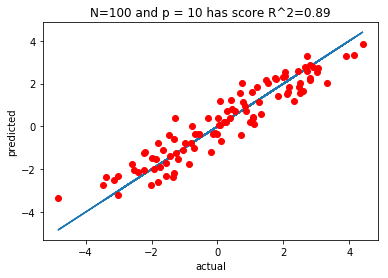

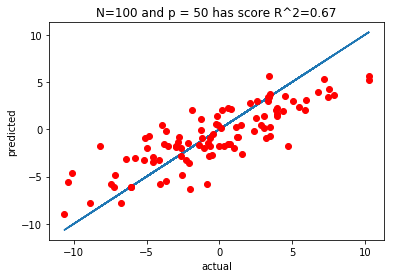

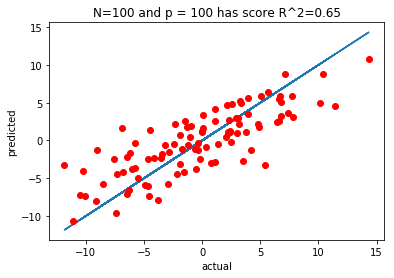

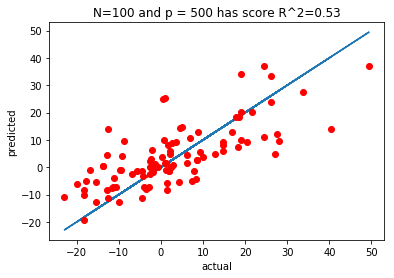

In [69]:
N=100
p=(10,50,100,500)
for i in range(len(p)):
    X = np.empty((N,p[i]))
    epsilon = np.empty((N,p[i]))
    for dim in range(p[i]):
        X[:,dim] = np.random.uniform(-1,1,N)
        epsilon[:,dim] = np.random.normal(0,0.1,100)
    y = np.sum(X,axis=1) +np.sum(epsilon,axis=1)

    neigh = KNeighborsRegressor(n_neighbors=2)
    neigh.fit(X, y) 

    y_hat = neigh.predict(X)
    r2 = round(neigh.score(X,y),2)
    
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(y,y )
    axes.plot(y,y_hat,'ro')
    axes.set_xlabel("actual")
    axes.set_ylabel("predicted")
    axes.set_title("N=100 and p = {0} has score R^2={1}".format(p[i],r2))

Based on our plot, we can see the prediciton become worse while we incresing the number of $p$, and $R^2$ is decreasing.

As $p$ increased, $(1-r^p)^N$ decraesed. This implies the probability of distance $P(y \geq R)$ is increased, and os our prediciton become worse. This fit with our result.

## Problem 2: Manual Model Selection

In this exercise, we have data which is sampled from a distribution which takes the form:
 $$y = \beta^T \cdot x + \epsilon.$$
 
 We are not told in advance what $\beta$ is though. That's up to you to discover. 

**[5 points]** a) Load the data `hw3.csv` into a Pandas dataframe located in `data/` in the course repository. Set $X$ to be the variables $0, \cdots, 50$ and $y$ to be the $y$ variable. 

In [77]:
df = pd.read_csv('hw3.csv')
y = df.loc[:,'y'].values
X = df.iloc[:,0:50].values
print(y)
print(X)

[ 0.32596856 -2.41131488 -1.26298389  1.67700342  1.04228116  1.66063313
 -1.70544694 -1.09743302 -1.27846932  0.78304557 -0.92835237 -0.31527636
 -2.58674468  0.51583514 -1.21117625  1.09807189 -0.89304048  0.18406748
  0.18113339 -0.38394834 -0.07054108 -1.04950197  0.04602003  0.30779392
  3.27634973 -0.7954778  -2.50948169  1.28236666 -1.8822229   0.39705185
  0.0104012   1.36557054 -2.67690973  1.33996402 -0.40039354  2.72932522
 -1.43744221  1.6676862   1.08083875 -1.78901403 -1.00346974 -1.60007273
  1.63276195 -0.22380526 -0.2013624   0.78658886 -0.22118713 -2.86622556
 -0.77976166 -1.65647704]
[[-0.07816122  0.1207129  -0.09778883 ...  0.03179791  0.0260633
   0.22215231]
 [-0.2310875   0.02271738  0.33841344 ...  0.05284821  0.1844702
   0.12936734]
 [-0.0976217   0.06812639  0.07881408 ...  0.00987037  0.06953125
   0.0890262 ]
 ...
 [-0.29122262 -0.0087193  -0.08487588 ...  0.05566987 -0.04925914
  -0.0757928 ]
 [ 0.00649065  0.11713066  0.10384516 ...  0.2381346  -0.243715

**[5 points]** b) Compute the covariance matrix of $X$ (ie. $X^TX$). What does this tell you about the features?

In [74]:
cov = X.transpose().dot(X)
cov

array([[ 1.00000000e+00, -6.79671601e-17, -1.38872404e-16, ...,
         1.50314520e-16, -3.36726761e-17,  2.36296654e-16],
       [-6.79671601e-17,  1.00000000e+00, -1.66463198e-16, ...,
         2.99372357e-17, -8.45772494e-17, -4.37812833e-17],
       [-1.38872404e-16, -1.66463198e-16,  1.00000000e+00, ...,
         3.86224145e-16, -2.34888101e-17,  6.00514529e-17],
       ...,
       [ 1.50314520e-16,  2.99372357e-17,  3.86224145e-16, ...,
         1.00000000e+00,  3.38803847e-18, -4.32402987e-17],
       [-3.36726761e-17, -8.45772494e-17, -2.34888101e-17, ...,
         3.38803847e-18,  1.00000000e+00,  2.91627593e-17],
       [ 2.36296654e-16, -4.37812833e-17,  6.00514529e-17, ...,
        -4.32402987e-17,  2.91627593e-17,  1.00000000e+00]])

This implies the covariance of each variables on $X$ is very small(or no covariance), ie they are not correlated.

**[10 points]** c) Starting $k$ from 1 and ranging to 50 (the total number of features), build a linear regression model  for $X[:,0:k]$ (where this denotes the matrix restricted to the first k columns), and plot the predictions against the actual values.  What happens as the number of features included increases? Why is this not surprising given what you know about linear alegbra and part b)? Recalling Homework 0 Problem 2 may be helpful. 

The following code will be useful:

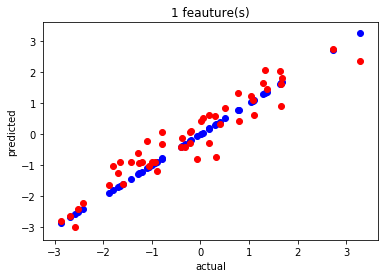

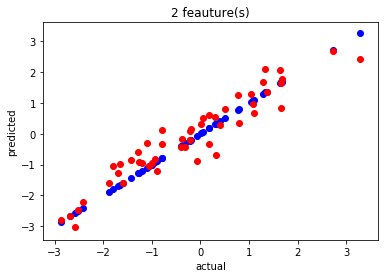

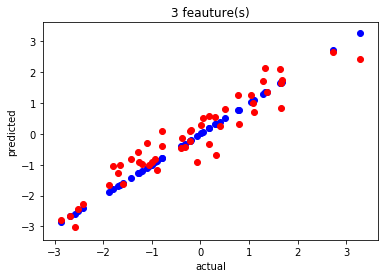

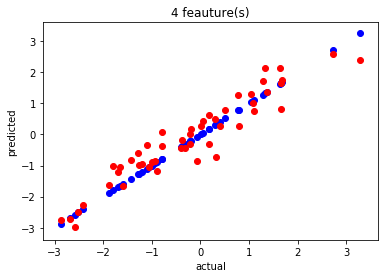

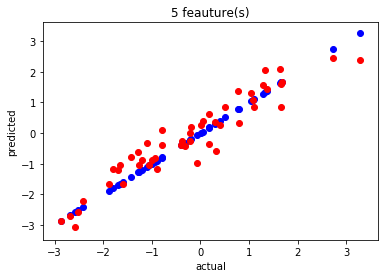

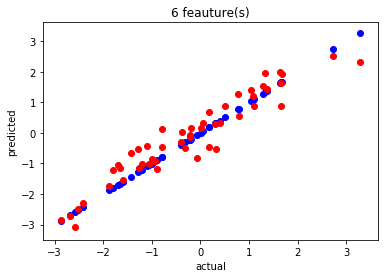

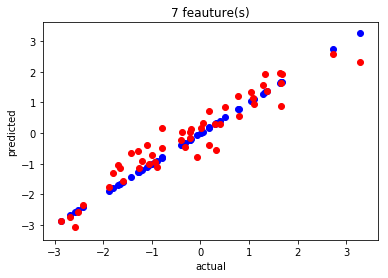

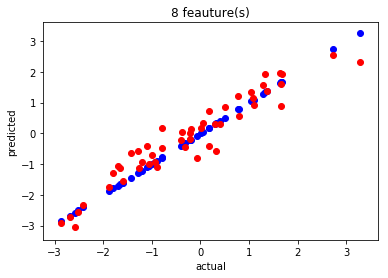

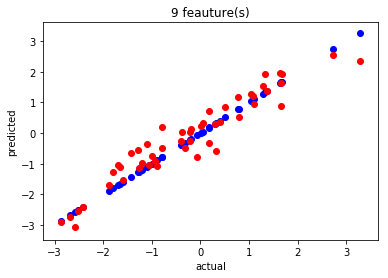

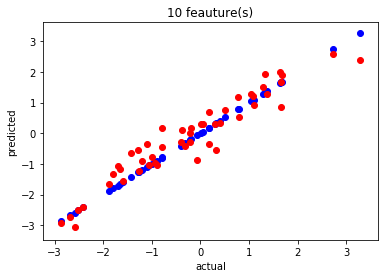

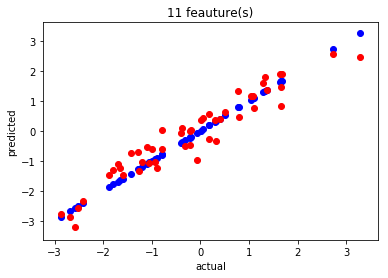

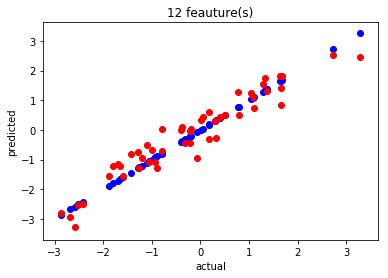

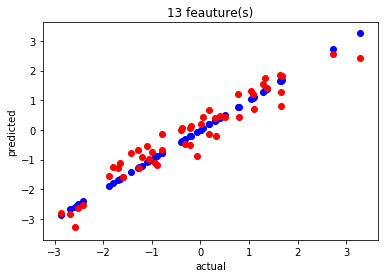

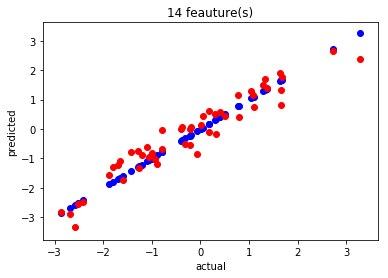

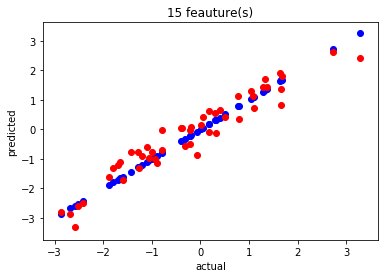

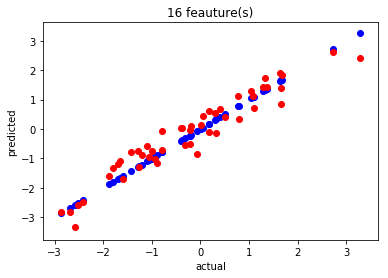

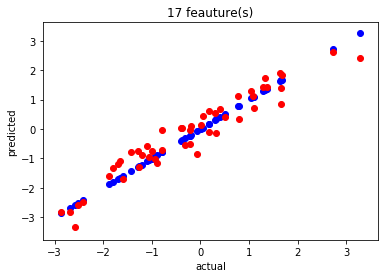

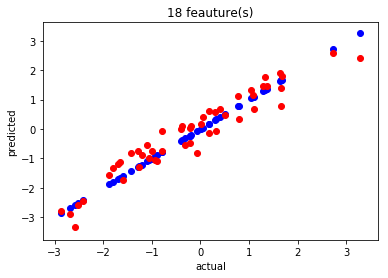

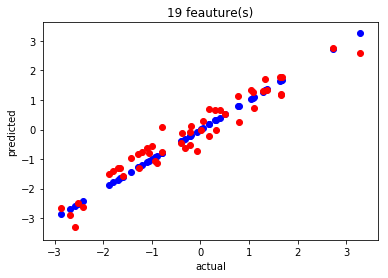

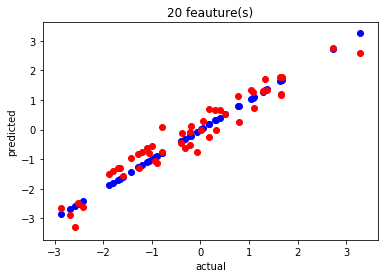

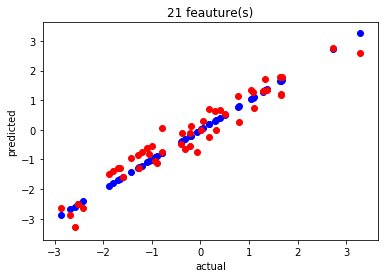

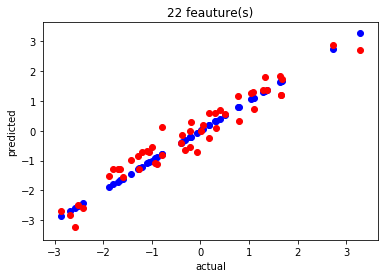

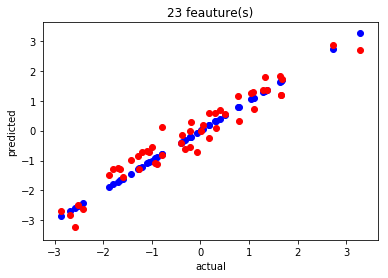

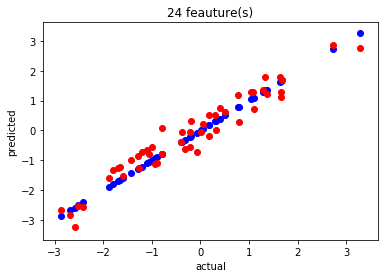

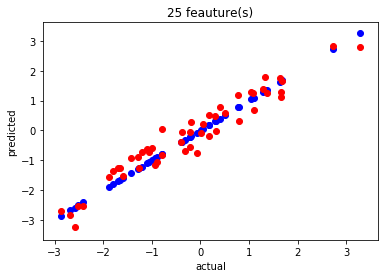

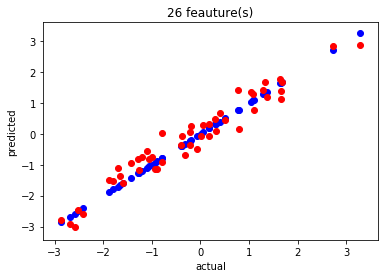

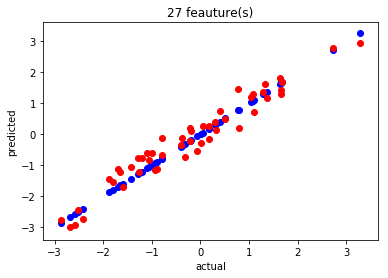

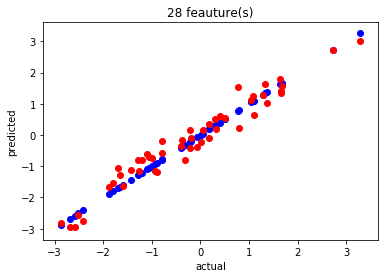

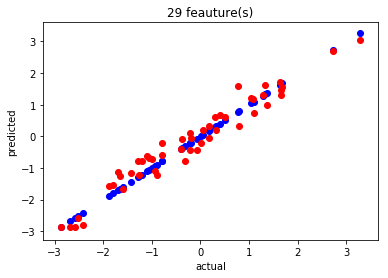

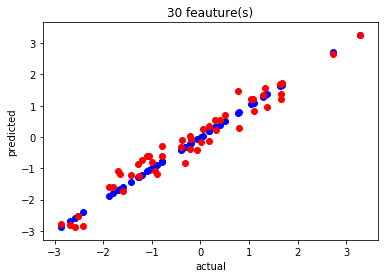

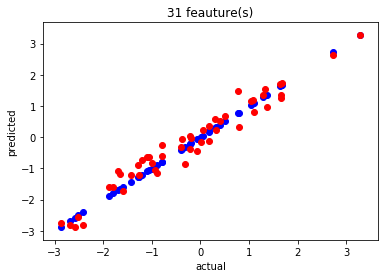

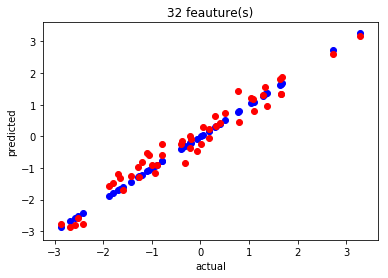

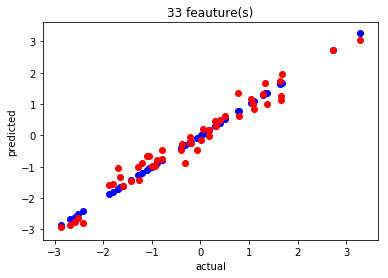

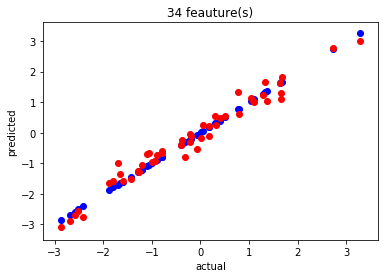

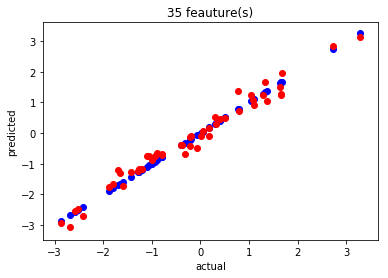

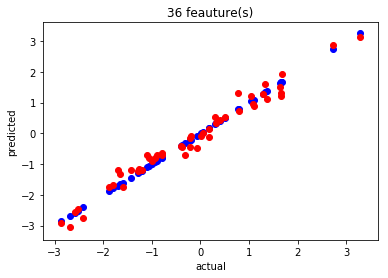

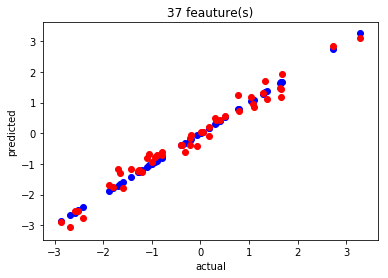

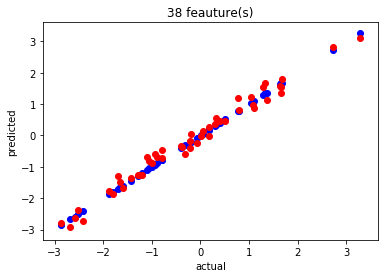

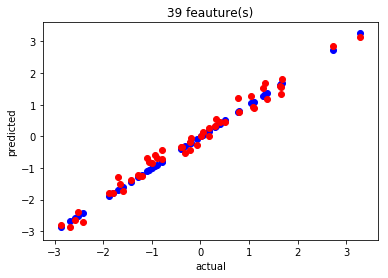

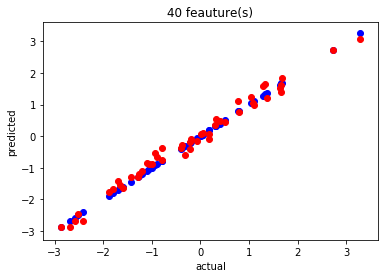

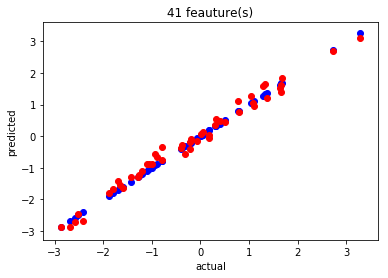

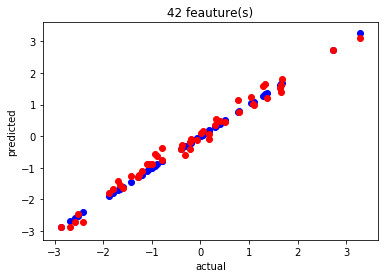

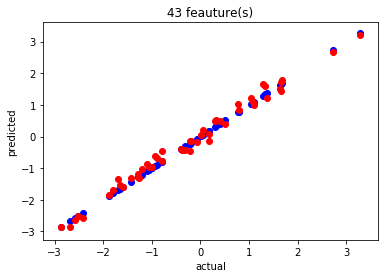

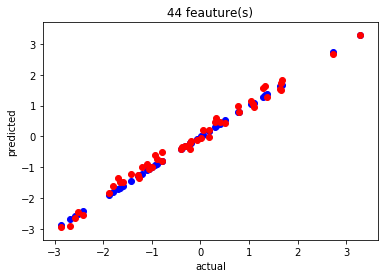

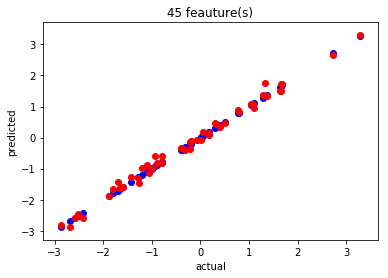

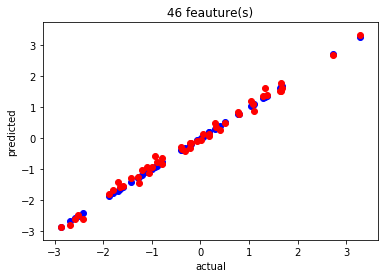

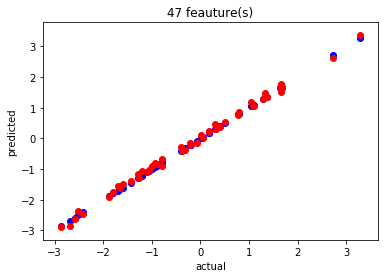

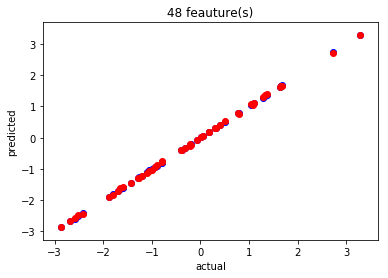

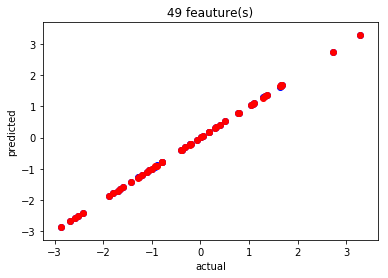

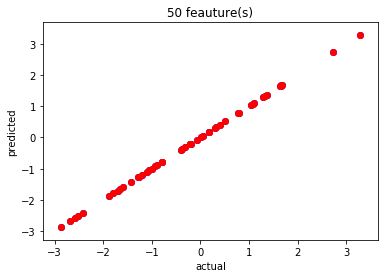

In [82]:
from sklearn import datasets, linear_model

for d in range(0,50):
    x0= X[:,0:(d+1)]
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(x0, y)
    y_pred = regr.predict(x0)
    plt.scatter(y,y,color='b')
    plt.scatter(y,y_pred,color='r')
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title("{0} feauture(s)".format(d+1))
    plt.show()

Based on the output, we can see as number of features increased, the prediciton becomes better. The reason is the variables are uncorrelated so each of them contribute to the $y$. Thus, when we include all features, the predictions of $y^hat$ values should be exactly the $y$ values

** [10 points] ** d) Split the data randomly into 80% training and 20% testing using `test_train_split` in Python. Repeat part c) on the training data, and
plot the $R^2$ of the model on the training and testing data against the number of features used. What happens to the training and testing error as you do this?

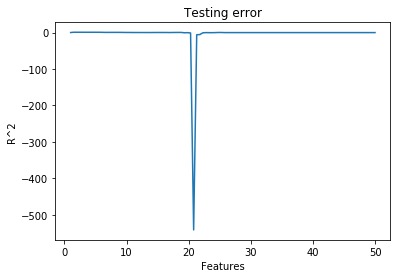

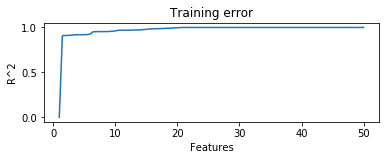

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random)
f = np.linspace(1,50,100)
r1 = np.empty(100)
r2 = np.empty(100)
for d in range(1,100):
    xtrain = X_train[:,0:d]
    xtest = X_test[:,0:d]
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(xtrain, y_train)
    y1 = regr.predict(xtest)
    r1[d]=sklearn.metrics.r2_score(y_test,y1)
    y2 = regr.predict(xtrain)
    r2[d]=sklearn.metrics.r2_score(y_train,y2)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(f,r1)
axes.set_xlabel("Features")
axes.set_ylabel("R^2")
axes.set_title("Testing error")
fig = plt.figure()
axes = fig.add_subplot(2, 1, 2)
axes.plot(f,r2)
axes.set_xlabel("Features")
axes.set_ylabel("R^2")
axes.set_title("Training error")
plt.show()

Based on our output, we can see as the number of features increased, training model peformence is increased($R^2$ increased). Testing model doesn't change much in this process, and its peformance is bad($R^2$ are around 0 all the time)

** [ 10 points] ** d) We would like to select the optimal subset of features which perform best on unseen data. If we were to evaluate all possible subsets of features out of $k$ features, what would the number of combinations be? Is this computationally feasible? 


**Hint:** What is the number of ways you can choose $m$ features out of $k$ total possible features? This is a common combinatorial expression. What happens when you sum this expression over $m$? The Theorem Statement of the Binomial Theorem here may be helpful: https://en.wikipedia.org/wiki/Binomial_theorem


Number of ways you can choose $m$ features out of $k$ total possible features is $\tbinom {k}{m}$.

Number of all possible features out of $k$ total possible features is: 

$\tbinom {k}{1}+\tbinom {k}{2}+ \dots + \tbinom {k}{k} = (1+1)^k - \tbinom {k}{0} = 2^k-1$

It's computationally feasible.

## Problem 3:  Ridge Regularization 

As an alternative approach, we can simply penalize the size of the coefficients in a way which minimizes our norm.

$$ \hat F_{\lambda}(\beta) :=  \|\mathbf{y} - \mathbf{X} \beta\|_{L^2}^2 + \lambda \|\beta\|_{L^2}^2. $$



**[5 points]** a) Do we need to scale our data in this case?

Yes, since the size of each feature is different, we have to scale them so that the penaliztion is same for each of them.

In [109]:
from sklearn import preprocessing
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
X_scaled = preprocessing.scale(X)

**[10 points]** a) 

Use our solution from class,

$$\beta_{\alpha} = (X^TX + \lambda I)^{-1}X^Ty$$

compute $\beta$ for an arbitrary value of $\alpha > 0$. 

In [108]:
beta = np.linalg.inv(X.transpose().dot(X)+0.5*np.eye(50)).dot(X.transpose()).dot(y)
beta

array([ 6.40373809e+00,  2.59075146e-01, -1.22183728e-01,  1.59835000e-01,
        3.21948251e-01, -5.01442647e-01,  2.17435295e-01, -4.15856494e-02,
       -1.48882045e-01,  2.00897064e-01, -5.61361958e-01,  2.98973701e-01,
        3.45663240e-01,  2.63789612e-01,  1.37117616e-01,  5.51780022e-02,
        1.17616807e-03,  1.35678651e-01,  6.66350675e-01,  1.39517085e-02,
        3.96924549e-02,  2.57035986e-01,  1.01838732e-02, -2.09633670e-01,
        1.31909404e-01, -4.96441749e-01, -4.32774960e-01, -4.10464866e-01,
       -2.22692031e-01, -3.24121317e-01,  9.66461340e-02,  3.85040956e-01,
        5.43566641e-01,  3.90025367e-01, -4.92840208e-01,  1.73605265e-01,
        2.59623100e-01,  4.87085535e-01,  1.37681659e-01, -3.40503218e-01,
        5.19689519e-02, -5.36823213e-02,  3.26687692e-01,  2.90887258e-01,
        3.38579559e-01, -2.33586426e-01,  4.38538940e-01,  3.87425712e-01,
        9.60798624e-02,  1.38882933e-02])

**[10 points]** b) Now repeat a) using `sklearn`'s `Ridge` method. But time time, use `test_train_split` to seperate
into training and testing data. Then evaluate performance for different values of $\alpha$. Can you find an $\alpha$ which has the best performance? 

The alpha that gives the best r2 is 1.0


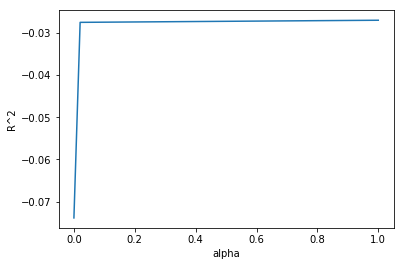

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=np.random)
N = 50
a = np.linspace(0,1,N)
r2 = np.empty(N)
for i in range(1,N):
    clf = sklearn.linear_model.Ridge(alpha = a[i])
    clf.fit(X_train,y_train)
    r2[i] = clf.score(X_test,y_test)
best = a[np.argmax(r2)]
print("The alpha that gives the best r2 is {0}".format(best))
plt.plot(a,r2)
plt.xlabel("alpha")
plt.ylabel("R^2")
plt.show()

**[10 points]** c) What do the coefficients look like for this optimal solution? You can answer this by plotting. Most importantly, do the maginitudes seem roughly comparable?

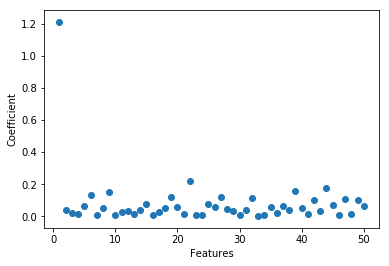

In [139]:
clf = sklearn.linear_model.Ridge(alpha = best)
clf.fit(X_train,y_train)
plt.scatter(np.linspace(1,50,N),np.abs(clf.coef_))
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

We can see it form our output. The magnitudes are roughly comparable.

## Problem 3: Lasso Reguarlization 

$$ \hat F_{\lambda}(\beta) :=  \|\mathbf{y} - \mathbf{X} \beta\|_{L^2}^2 + \lambda \|\beta\|_{L^1}, $$


a) Now repeat Problem 2 b) using `sklearn`'s `Lasso` method. How does the optimal performance seem to compare to that of `Ridge`? Ensure you are training on training data and evaluating on testing data. 

The alpha that gives the best r2 is 0.04081632653061224


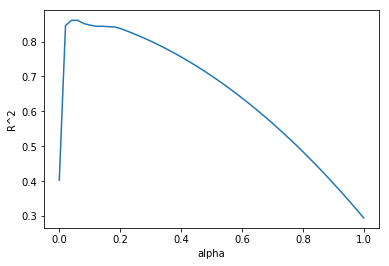

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=np.random)
N = 50
a = np.linspace(0,1,N)
r2 = np.empty(N)
for i in range(1,N):
    clf = sklearn.linear_model.Lasso(alpha = a[i])
    clf.fit(X_train,y_train)
    r2[i] = clf.score(X_test,y_test)
best = a[np.argmax(r2)]
print("The alpha that gives the best r2 is {0}".format(best))
plt.plot(a,r2)
plt.xlabel("alpha")
plt.ylabel("R^2")
plt.show()

Based on the output, Lasso method perform better than Ridge method.

b) What do the coefficients look like for the optimal $\lambda$ found above? How can you interpret this based on the level sets of $L^1$?

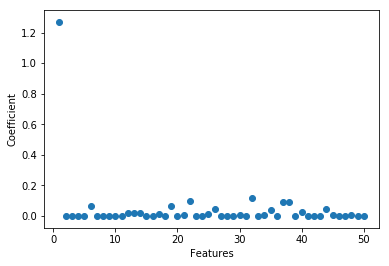

In [133]:
clf = sklearn.linear_model.Lasso(alpha = best)
clf.fit(X_train,y_train)
plt.scatter(np.linspace(1,50,N),np.abs(clf.coef_))
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

Based on our output, the coefficient values are colse to each other. $L^1$ is the sum of absolute values of the vector, in this case, $L^1$'s are closed then so for the coefficients